# How to Query Past PnL Data from the Database

This notebook teaches you how to query historical P&L (Profit & Loss) data from your local SQLite database.

## What You'll Learn

1. Understanding the PnL data structure
2. Using CLI commands for quick queries
3. Using Python API for advanced analysis
4. Writing direct SQL queries
5. Common use cases and visualizations

## 1. Setup

First, let's set up the Python path and import necessary libraries.

In [1]:
# Setup: Add project root to Python path and change working directory
import sys
import os
from pathlib import Path

# Get the project root directory
project_root = Path().resolve()
if project_root.name == 'notebooks':
    project_root = project_root.parent

project_root_str = str(project_root.resolve())
if project_root_str not in sys.path:
    sys.path.insert(0, project_root_str)

# Change working directory to project root so database paths resolve correctly
os.chdir(project_root_str)

print(f"Project root: {project_root_str}")
print(f"Working directory: {os.getcwd()}")

Project root: /Users/zelin/Desktop/PA Investment/Invest_strategy
Working directory: /Users/zelin/Desktop/PA Investment/Invest_strategy


In [2]:
# Check and initialize database if needed
from backend.config import settings
from backend.database import engine
from sqlalchemy import inspect, text
from pathlib import Path

# Verify we're using the correct database file
db_path = Path("ibkr_analytics.db").resolve()
print(f"Database path: {db_path}")
print(f"Database exists: {db_path.exists()}")
print(f"Database URL: {settings.database.url}")

# Check if database tables exist
inspector = inspect(engine)
existing_tables = inspector.get_table_names()
print(f"Existing tables: {existing_tables}")

# If tables don't exist, initialize database
if "trades" not in existing_tables:
    print("\n⚠️  Database tables not found! Initializing database...")
    from backend.db_utils import init_database
    init_database()
    
    # Verify tables were created
    inspector = inspect(engine)
    new_tables = inspector.get_table_names()
    print(f"✓ Tables created: {new_tables}")
else:
    print("✓ Database tables already exist")
    
    # Check if there's data - use direct SQL query first to verify
    try:
        with engine.connect() as conn:
            result = conn.execute(text("SELECT COUNT(*) as count FROM trades"))
            direct_count = result.scalar()
            print(f"\nDirect SQL query: {direct_count} trades in database")
    except Exception as e:
        print(f"\n⚠️  Error querying database directly: {e}")
        direct_count = 0
    
    # Also check using db_utils function
    from backend.db_utils import get_account_pnl_totals, get_trades_df
    try:
        totals = get_account_pnl_totals()
        print(f"get_account_pnl_totals(): {totals['trade_count']} trades")
        print(f"  Total P&L (USD): ${totals['total_pnl_usd']:,.2f}")
        print(f"  Total P&L (HKD): HK${totals['total_pnl_hkd']:,.2f}")
        
        # Also verify with get_trades_df
        sample_trades = get_trades_df(limit=1)
        print(f"get_trades_df(limit=1): {len(sample_trades)} trade(s) retrieved")
        
        if totals['trade_count'] == 0 and direct_count and direct_count > 0:
            print("\n⚠️  Warning: db_utils function returned 0 but direct query found trades!")
            print("  This might indicate a database connection issue. Try restarting the kernel.")
    except Exception as e:
        print(f"\n⚠️  Error using db_utils: {e}")
        import traceback
        traceback.print_exc()

Database path: /Users/zelin/Desktop/PA Investment/Invest_strategy/ibkr_analytics.db
Database exists: True
Database URL: sqlite:///./ibkr_analytics.db
Existing tables: ['account_snapshots', 'execution_fills', 'execution_orders', 'performance_metrics', 'pnl_history', 'positions', 'risk_events', 'trades']
✓ Database tables already exist

Direct SQL query: 100 trades in database
get_account_pnl_totals(): 100 trades
  Total P&L (USD): $-4,180.98
  Total P&L (HKD): HK$-32,528.05
get_trades_df(limit=1): 1 trade(s) retrieved


In [3]:
# Import database utilities and other libraries
from backend.db_utils import (
    get_trades_df,
    get_daily_pnl,
    get_trade_summary,
    get_account_pnl_totals,
    query_trades,
    get_daily_returns
)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

print("✓ Imports successful")

✓ Imports successful


## 2. Understanding Data Structure

Your database stores PnL data in two main tables:

### `trades` Table
Contains individual trade executions with realized P&L:
- `exec_time`: When the trade was executed
- `symbol`: Stock/option symbol
- `side`: BUY or SELL
- `shares`: Number of shares/contracts
- `price`: Execution price
- `realized_pnl`: P&L in trade currency (USD, HKD, etc.)
- `realized_pnl_base`: P&L in base currency (HKD)
- `commission`: Commission paid

### `pnl_history` Table
Contains daily aggregated P&L snapshots:
- `date`: Date of the snapshot
- `realized_pnl`: Realized P&L for the day
- `unrealized_pnl`: Unrealized P&L (mark-to-market)
- `total_pnl`: Total P&L (realized + unrealized)
- `net_liquidation`: Account value
- `total_cash`: Cash balance

In [4]:
# Let's check what data we have
print("Checking database contents...")

try:
    # Get total counts
    totals = get_account_pnl_totals()
    print(f"\nTotal Trades: {totals['trade_count']}")
    print(f"Total P&L (USD): ${totals['total_pnl_usd']:,.2f}")
    print(f"Total P&L (HKD): HK${totals['total_pnl_hkd']:,.2f}")
    print(f"Total Commissions: ${totals['total_commissions']:,.2f}")

    # Get a sample of trades to see the structure
    sample_trades = get_trades_df()
    if not sample_trades.empty:
        print("\nSample trades:")
        # Select only columns that exist
        display_cols = ['exec_time', 'symbol', 'side', 'shares', 'price', 'realized_pnl']
        available_cols = [col for col in display_cols if col in sample_trades.columns]
        print(sample_trades[available_cols].to_string(index=False))
    else:
        print("\n✓ Database initialized, but no trades found yet.")
        print("  Import trades using:")
        print("  PYTHONPATH='$(pwd)' python -m backend.db_utils import")
        print("  Or fetch from Flex Query via the frontend at http://localhost:8050")
except Exception as e:
    print(f"\n❌ Error: {e}")
    import traceback
    traceback.print_exc()
    print("\nIf you see 'no such table', make sure you ran the previous cell to initialize the database.")
    print("Or manually run:")
    print("  from backend.db_utils import init_database")
    print("  init_database()")

Checking database contents...

Total Trades: 100
Total P&L (USD): $-4,180.98
Total P&L (HKD): HK$-32,528.05
Total Commissions: $-1,124.96

Sample trades:
          exec_time                symbol side       shares     price  realized_pnl
2025-12-29 08:44:37                   IAU SELL   160.000000  83.38000   4317.073043
2025-12-29 08:44:37                   IAU SELL    18.000000  83.38000    584.011784
2025-11-05 11:13:01               USD.HKD SELL     0.054758   7.77575      0.000000
2025-11-05 11:13:01               USD.HKD  BUY     8.900000   7.77544      0.000000
2025-11-05 11:13:01               USD.HKD  BUY    81.100000   7.77575      0.000000
2025-11-05 02:57:46               USD.HKD  BUY  3244.660000   7.77399      0.000000
2025-11-03 09:37:38                   XLK  BUY    11.000000 303.05500      0.000000
2025-10-09 21:07:38               USD.HKD  BUY    33.000000   7.78240      0.000000
2025-10-09 21:07:38               USD.HKD  BUY     0.488972   7.78240      0.000000
2025-1

In [26]:
returns = get_daily_returns(
    use_pnl_history=True
)
returns.head(30)

,date,account_id,net_liquidation,total_cash,realized_pnl,unrealized_pnl,total_pnl,mtm,daily_return,cumulative_return
1,2025-01-14,U13798787,158794.228851,NaN,0.0,294.908560,294.908560,294.908560,0.001860,0.001860
2,2025-01-15,U13798787,160817.960888,NaN,0.0,2047.006968,2047.006968,2047.006968,0.012891,0.014775
3,2025-01-16,U13798787,161017.539408,NaN,0.0,222.878987,222.878987,222.878987,0.001386,0.016182
4,2025-01-17,U13798787,157717.052361,NaN,0.0,-1918.022162,-1918.022162,-1918.022162,-0.011912,0.004077
5,2025-01-20,U13798787,157611.690426,NaN,0.0,-105.531727,-105.531727,-105.531727,-0.000669,0.003405
6,2025-01-21,U13798787,206183.421509,NaN,0.0,-1265.285856,-1265.285856,-1265.285856,-0.008028,-0.004650
7,2025-01-22,U13798787,257910.457611,NaN,0.0,1777.778251,1777.778251,1777.778251,0.008622,0.003932
8,2025-01-23,U13798787,257897.574290,NaN,0.0,-3.030516,-3.030516,-3.030516,-0.000012,0.003920
9,2025-01-24,U13798787,258006.565864,NaN,0.0,117.997580,117.997580,117.997580,0.000458,0.004380
10,2025-01-27,U13798787,256334.943864,NaN,0.0,-1259.572413,-1259.572413,-1259.572413,-0.004882,-0.000524


## 3. Quick Queries with CLI

The easiest way to query PnL data is using built-in CLI commands. You can run these in your terminal:

```bash
cd "/Users/zelin/Desktop/PA Investment/Invest_strategy"
conda activate ibkr-analytics

# View daily P&L
PYTHONPATH="$(pwd)" python -m backend.db_utils daily

# View summary by symbol
PYTHONPATH="$(pwd)" python -m backend.db_utils summary

# View totals
PYTHONPATH="$(pwd)" python -m backend.db_utils totals
```

But we can also call these functions directly in Python!

### 3.1 Get Total P&L Overview

In [6]:
# Get overall totals
totals = get_account_pnl_totals()

print("=" * 60)
print("TOTAL P&L OVERVIEW")
print("=" * 60)
print(f"Total P&L (USD): ${totals['total_pnl_usd']:,.2f}")
print(f"Total P&L (HKD): HK${totals['total_pnl_hkd']:,.2f}")
print(f"Total Commissions: ${totals['total_commissions']:,.2f}")
print(f"Total Trades: {totals['trade_count']}")

TOTAL P&L OVERVIEW
Total P&L (USD): $-4,180.98
Total P&L (HKD): HK$-32,528.05
Total Commissions: $-1,124.96
Total Trades: 100


### 3.2 Get Daily P&L

In [7]:
# Get daily P&L with cumulative totals
daily = get_daily_pnl()

if not daily.empty:
    print("=" * 80)
    print("DAILY P&L (Last 10 Days)")
    print("=" * 80)
    
    # Show last 10 days - ensure columns exist
    display_cols = ['date', 'trade_count', 'realized_pnl', 'realized_pnl_hkd', 
                   'cumulative_pnl_usd', 'cumulative_pnl_hkd']
    available_cols = [col for col in display_cols if col in daily.columns]
    print(daily[available_cols].tail(10).to_string(index=False))
    
    # Statistics
    print("\n" + "=" * 80)
    print("STATISTICS")
    print("=" * 80)
    print(f"Best day: ${daily['realized_pnl'].max():,.2f}")
    print(f"Worst day: ${daily['realized_pnl'].min():,.2f}")
    print(f"Average daily P&L: ${daily['realized_pnl'].mean():,.2f}")
    print(f"Days with positive P&L: {(daily['realized_pnl'] > 0).sum()}")
    print(f"Days with negative P&L: {(daily['realized_pnl'] < 0).sum()}")
    print(f"Total days: {len(daily)}")
else:
    print("No daily P&L data available. Import trades first.")
    print("You can import trades using:")
    print("  PYTHONPATH='$(pwd)' python -m backend.db_utils import")

DAILY P&L (Last 10 Days)
      date  trade_count  realized_pnl  realized_pnl_hkd  cumulative_pnl_usd  cumulative_pnl_hkd
2025-04-04            2      0.000000          0.000000          490.718436         3817.789432
2025-05-12           11 -11449.498000     -89077.094440       -10958.779564       -85259.305008
2025-05-19            7    400.356000       3114.769680       -10558.423564       -82144.535328
2025-05-21            5   1476.356000      11486.049680        -9082.067564       -70658.485648
2025-05-22            1      0.000000          0.000000        -9082.067564       -70658.485648
2025-08-11            3      0.000000          0.000000        -9082.067564       -70658.485648
2025-10-09            3      0.000000          0.000000        -9082.067564       -70658.485648
2025-11-03            1      0.000000          0.000000        -9082.067564       -70658.485648
2025-11-05            4      0.000000          0.000000        -9082.067564       -70658.485648
2025-12-29     

### 3.3 Get Trade Summary by Symbol

In [8]:
# Get P&L summary grouped by symbol
summary = get_trade_summary()

if not summary.empty:
    print("=" * 80)
    print("P&L BY SYMBOL (Top 10)")
    print("=" * 80)
    
    # Show top 10 symbols - ensure columns exist
    top_symbols = summary.head(10)
    display_cols = ['trade_count', 'realized_pnl_usd', 'realized_pnl_hkd']
    available_cols = [col for col in display_cols if col in top_symbols.columns]
    
    # Reset index to show symbol names
    top_symbols_display = top_symbols.reset_index()[['symbol'] + available_cols]
    print(top_symbols_display.to_string(index=False))
    
    # Best and worst performers
    print("\n" + "=" * 80)
    print("BEST PERFORMERS")
    print("=" * 80)
    best = summary.nlargest(5, 'realized_pnl_usd').reset_index()
    print(best[['symbol', 'trade_count', 'realized_pnl_usd']].to_string(index=False))
    
    print("\n" + "=" * 80)
    print("WORST PERFORMERS")
    print("=" * 80)
    worst = summary.nsmallest(5, 'realized_pnl_usd').reset_index()
    print(worst[['symbol', 'trade_count', 'realized_pnl_usd']].to_string(index=False))
else:
    print("No trade summary data available.")
    print("Import trades first using:")
    print("  PYTHONPATH='$(pwd)' python -m backend.db_utils import")

P&L BY SYMBOL (Top 10)
               symbol  trade_count  realized_pnl_usd  realized_pnl_hkd
                  IAU            8       4901.084827      38130.439954
VIX   250618P00019000            5       2154.384000      16761.107520
VIX   250318P00021000            8        961.121000       7477.521380
VIX   250318P00019000            2        386.845000       3009.654100
                  IVV            6        227.296297       1768.365191
VIX   250716C00016000            3        152.053500       1182.976230
                  TLT            6         33.179139        258.133701
                 COPX            1          0.000000          0.000000
              HKD.JPY            1          0.000000          0.000000
                  XLK            1          0.000000          0.000000

BEST PERFORMERS
               symbol  trade_count  realized_pnl_usd
                  IAU            8       4901.084827
VIX   250618P00019000            5       2154.384000
VIX   250318P0002100

## 4. Python API Examples

Now let's explore more advanced filtering and analysis using the Python API.

### 4.1 Filter Trades by Date Range

In [9]:
# Get trades from a specific date range
# Adjust these dates to match your data
start_date = "2025-01-01"
end_date = "2025-01-31"

monthly_trades = get_trades_df(
    start_date=start_date,
    end_date=end_date
)

if not monthly_trades.empty:
    monthly_pnl = monthly_trades['realized_pnl'].sum()
    print(f"Trades in {start_date} to {end_date}: {len(monthly_trades)}")
    print(f"Total P&L for period: ${monthly_pnl:,.2f}")
    print(f"Average P&L per trade: ${monthly_pnl/len(monthly_trades):,.2f}")
    
    # Show sample
    print("\nSample trades:")
    print(monthly_trades[['exec_time', 'symbol', 'side', 'realized_pnl']].head(10).to_string(index=False))
else:
    print(f"No trades found for {start_date} to {end_date}")

Trades in 2025-01-01 to 2025-01-31: 43
Total P&L for period: $-280.66
Average P&L per trade: $-6.53

Sample trades:
          exec_time                symbol side  realized_pnl
2025-01-29 10:23:56 VIX   250318P00021000 SELL    837.752000
2025-01-28 10:52:29 VIX   250318P00021000 SELL    123.369000
2025-01-28 10:52:29 VIX   250318C00021000 SELL   -186.331000
2025-01-27 11:02:14                   TLT SELL     10.682008
2025-01-27 10:59:35 VIX   250318P00021000  BUY      0.000000
2025-01-27 10:59:35 VIX   250318P00021000  BUY      0.000000
2025-01-27 10:57:12 VIX   250318C00021000 SELL   -190.396500
2025-01-27 10:16:12 VIX   250318P00021000  BUY      0.000000
2025-01-27 10:16:12 VIX   250318P00021000  BUY      0.000000
2025-01-27 10:16:12 VIX   250318P00021000  BUY      0.000000


### 4.2 Filter by Symbol

In [10]:
# Get all trades for a specific symbol
# First, let's see what symbols are available
all_trades = get_trades_df(limit=1000)
if not all_trades.empty:
    available_symbols = sorted(all_trades['symbol'].unique())
    print(f"Available symbols ({len(available_symbols)}): {', '.join(available_symbols[:10])}")
    if len(available_symbols) > 10:
        print(f"... and {len(available_symbols) - 10} more")
    
    # Use the first available symbol as example, or change this
    symbol = available_symbols[0] if available_symbols else "AAPL"
    print(f"\nAnalyzing symbol: {symbol}")
else:
    symbol = "AAPL"  # Default if no data
    print(f"No trades in database. Using example symbol: {symbol}")

symbol_trades = get_trades_df(symbol=symbol)

if not symbol_trades.empty:
    symbol_pnl = symbol_trades['realized_pnl'].sum()
    symbol_pnl_hkd = symbol_trades['realized_pnl_hkd'].sum()
    
    print("=" * 60)
    print(f"{symbol} TRADE ANALYSIS")
    print("=" * 60)
    print(f"Total Trades: {len(symbol_trades)}")
    print(f"Total P&L (USD): ${symbol_pnl:,.2f}")
    print(f"Total P&L (HKD): HK${symbol_pnl_hkd:,.2f}")
    print(f"Average P&L per trade: ${symbol_pnl/len(symbol_trades):,.2f}")
    
    # Buy vs Sell breakdown
    buy_trades = symbol_trades[symbol_trades['side'] == 'BUY']
    sell_trades = symbol_trades[symbol_trades['side'] == 'SELL']
    
    print(f"\nBuy trades: {len(buy_trades)}")
    print(f"Sell trades: {len(sell_trades)}")
    
    # Show recent trades
    print("\nRecent trades:")
    display_cols = ['exec_time', 'side', 'shares', 'price', 'realized_pnl']
    available_cols = [col for col in display_cols if col in symbol_trades.columns]
    print(symbol_trades[available_cols].head(10).to_string(index=False))
else:
    print(f"No trades found for symbol: {symbol}")
    if not all_trades.empty:
        print("\nAvailable symbols:")
        print(all_trades['symbol'].unique()[:20])

Available symbols (20): COPX, HKD.JPY, IAU, IEF, IVV, TLT, USD.HKD, USD.JPY, VIX   250122C00013500, VIX   250122C00016000
... and 10 more

Analyzing symbol: COPX
COPX TRADE ANALYSIS
Total Trades: 1
Total P&L (USD): $0.00
Total P&L (HKD): HK$0.00
Average P&L per trade: $0.00

Buy trades: 1
Sell trades: 0

Recent trades:
          exec_time side  shares  price  realized_pnl
2025-10-09 20:55:13  BUY    60.0  64.47           0.0


### 4.3 Filter by Side (BUY/SELL)

In [11]:
# Compare BUY vs SELL trades
buy_trades = get_trades_df(side="BUY")
sell_trades = get_trades_df(side="SELL")

if not buy_trades.empty and not sell_trades.empty:
    print("=" * 60)
    print("BUY vs SELL COMPARISON")
    print("=" * 60)
    
    buy_pnl = buy_trades['realized_pnl'].sum()
    sell_pnl = sell_trades['realized_pnl'].sum()
    
    print(f"BUY Trades: {len(buy_trades)}")
    print(f"  Total P&L: ${buy_pnl:,.2f}")
    print(f"  Avg P&L: ${buy_pnl/len(buy_trades):,.2f}")
    
    print(f"\nSELL Trades: {len(sell_trades)}")
    print(f"  Total P&L: ${sell_pnl:,.2f}")
    print(f"  Avg P&L: ${sell_pnl/len(sell_trades):,.2f}")

BUY vs SELL COMPARISON
BUY Trades: 61
  Total P&L: $-378.45
  Avg P&L: $-6.20

SELL Trades: 39
  Total P&L: $-3,802.54
  Avg P&L: $-97.50


### 4.4 Pattern Matching (e.g., All VIX Options)

In [12]:
# Use % as wildcard for pattern matching
# This example finds all VIX-related trades
vix_trades = get_trades_df(symbol="VIX%")

if not vix_trades.empty:
    print(f"Found {len(vix_trades)} VIX-related trades")
    print(f"Total P&L (USD): ${vix_trades['realized_pnl'].sum():,.2f}")
    print(f"Total P&L (HKD): HK${vix_trades['realized_pnl_hkd'].sum():,.2f}")
    print("\nUnique symbols:")
    print(sorted(vix_trades['symbol'].unique()))
else:
    print("No VIX trades found.")
    # Try to find any pattern matches
    all_trades = get_trades_df(limit=1000)
    if not all_trades.empty:
        print("\nAvailable symbols (first 20):")
        print(sorted(all_trades['symbol'].unique())[:20])
        print("\nTry a different pattern like:")
        print("  - get_trades_df(symbol='IAU%')  # For IAU-related")
        print("  - get_trades_df(symbol='%')      # For all trades")

Found 55 VIX-related trades
Total P&L (USD): $-9,342.54
Total P&L (HKD): HK$-72,684.98

Unique symbols:
['VIX   250122C00013500', 'VIX   250122C00016000', 'VIX   250122C00024000', 'VIX   250318C00021000', 'VIX   250318P00019000', 'VIX   250318P00021000', 'VIX   250521P00018000', 'VIX   250618P00017000', 'VIX   250618P00019000', 'VIX   250716C00016000', 'VIX   250716P00016000']


## 5. Direct SQL Queries

For maximum flexibility, you can write custom SQL queries.

### 5.1 Monthly P&L Summary

In [13]:
# Get monthly P&L summary using SQL
monthly = query_trades("""
    SELECT 
        strftime('%Y-%m', exec_time) as month,
        COUNT(*) as trades,
        SUM(realized_pnl) as pnl_usd,
        SUM(realized_pnl_base) as pnl_hkd,
        SUM(commission) as commissions
    FROM trades 
    GROUP BY month 
    ORDER BY month DESC
    LIMIT 12
""")

if not monthly.empty:
    print("=" * 70)
    print("MONTHLY P&L SUMMARY (Last 12 Months)")
    print("=" * 70)
    print(monthly.to_string(index=False))
    
    # Summary stats
    print("\n" + "=" * 70)
    print("SUMMARY")
    print("=" * 70)
    print(f"Total months: {len(monthly)}")
    print(f"Best month: {monthly.loc[monthly['pnl_usd'].idxmax(), 'month']} (${monthly['pnl_usd'].max():,.2f})")
    print(f"Worst month: {monthly.loc[monthly['pnl_usd'].idxmin(), 'month']} (${monthly['pnl_usd'].min():,.2f})")
else:
    print("No monthly data available")
    print("Make sure you have trades in the database.")

MONTHLY P&L SUMMARY (Last 12 Months)
  month  trades      pnl_usd       pnl_hkd  commissions
2025-12       2  4901.084827  38130.439954    -1.029548
2025-11       5     0.000000      0.000000   -32.097442
2025-10       3     0.000000      0.000000   -16.565520
2025-08       3     0.000000      0.000000   -47.098800
2025-05      24 -9572.786000 -74476.275080  -366.461952
2025-04       2     0.000000      0.000000   -92.336400
2025-03       2     0.000000      0.000000   -48.816300
2025-02      16   771.380835   6001.342896  -237.510341
2025-01      43  -280.662399  -2183.553464  -283.045747

SUMMARY
Total months: 9
Best month: 2025-12 ($4,901.08)
Worst month: 2025-05 ($-9,572.79)


### 5.2 Win/Loss Statistics

In [14]:
# Calculate win/loss statistics
win_loss = query_trades("""
    SELECT 
        CASE 
            WHEN realized_pnl > 0 THEN 'Win'
            WHEN realized_pnl < 0 THEN 'Loss'
            ELSE 'Breakeven'
        END as outcome,
        COUNT(*) as count,
        SUM(realized_pnl) as total_pnl,
        SUM(realized_pnl_base) as total_pnl_hkd,
        AVG(realized_pnl) as avg_pnl,
        MIN(realized_pnl) as worst_trade,
        MAX(realized_pnl) as best_trade
    FROM trades 
    WHERE realized_pnl IS NOT NULL
    GROUP BY outcome
    ORDER BY 
        CASE outcome
            WHEN 'Win' THEN 1
            WHEN 'Loss' THEN 2
            ELSE 3
        END
""")

if not win_loss.empty:
    print("=" * 70)
    print("WIN/LOSS STATISTICS")
    print("=" * 70)
    print(win_loss.to_string(index=False))
    
    # Calculate win rate
    total = win_loss['count'].sum()
    wins_row = win_loss[win_loss['outcome'] == 'Win']
    wins = wins_row['count'].sum() if not wins_row.empty else 0
    win_rate = (wins / total * 100) if total > 0 else 0
    
    print(f"\nWin Rate: {win_rate:.2f}%")
    print(f"Total Trades: {total}")
    print(f"Winning Trades: {int(wins)}")
    print(f"Losing Trades: {int(win_loss[win_loss['outcome'] == 'Loss']['count'].sum()) if not win_loss[win_loss['outcome'] == 'Loss'].empty else 0}")
else:
    print("No win/loss data available")
    print("Make sure you have trades with realized_pnl in the database.")

WIN/LOSS STATISTICS
  outcome  count     total_pnl  total_pnl_hkd     avg_pnl  worst_trade  best_trade
      Win     18   9105.352763   70839.644496  505.852931    10.682008 4317.073043
     Loss     17 -13286.335500 -103367.690190 -781.549147 -4418.060000  -11.665500
Breakeven     65      0.000000       0.000000    0.000000     0.000000    0.000000

Win Rate: 18.00%
Total Trades: 100
Winning Trades: 18
Losing Trades: 17


### 5.3 Top 10 Best/Worst Trades

In [15]:
# Best trades
best_trades = query_trades("""
    SELECT 
        exec_time,
        symbol,
        side,
        shares,
        price,
        realized_pnl,
        currency
    FROM trades 
    WHERE realized_pnl > 0
    ORDER BY realized_pnl DESC
    LIMIT 10
""")

if not best_trades.empty:
    print("=" * 80)
    print("TOP 10 BEST TRADES")
    print("=" * 80)
    print(best_trades.to_string(index=False))

# Worst trades
worst_trades = query_trades("""
    SELECT 
        exec_time,
        symbol,
        side,
        shares,
        price,
        realized_pnl,
        currency
    FROM trades 
    WHERE realized_pnl < 0
    ORDER BY realized_pnl ASC
    LIMIT 10
""")

if not worst_trades.empty:
    print("\n" + "=" * 80)
    print("TOP 10 WORST TRADES")
    print("=" * 80)
    print(worst_trades.to_string(index=False))

TOP 10 BEST TRADES
                 exec_time                symbol side  shares  price  realized_pnl currency
2025-12-29 08:44:37.000000                   IAU SELL   160.0  83.38   4317.073043      USD
2025-01-29 10:23:56.000000 VIX   250318P00021000 SELL    16.0   4.95    837.752000      USD
2025-05-19 05:33:11.000000 VIX   250618P00019000 SELL    40.0   1.20    797.192000      USD
2025-12-29 08:44:37.000000                   IAU SELL    18.0  83.38    584.011784      USD
2025-05-21 09:57:16.000000 VIX   250618P00019000 SELL    16.0   1.34    542.876800      USD
2025-05-21 09:57:16.000000 VIX   250618P00019000 SELL    12.0   1.34    407.157600      USD
2025-05-21 09:57:16.000000 VIX   250618P00019000 SELL    12.0   1.34    407.157600      USD
2025-02-03 10:44:31.000000 VIX   250318P00019000 SELL    10.0   3.05    386.845000      USD
2025-02-26 11:08:26.000000 VIX   250521P00018000 SELL    50.0   2.20    170.225000      USD
2025-01-27 05:46:04.000000 VIX   250716C00016000 SELL     3.0

### 5.4 P&L by Security Type

In [16]:
# Analyze P&L by security type (STK, OPT, FUT, etc.)
by_type = query_trades("""
    SELECT 
        COALESCE(sec_type, 'UNKNOWN') as sec_type,
        COUNT(*) as trades,
        SUM(realized_pnl) as pnl_usd,
        SUM(realized_pnl_base) as pnl_hkd,
        SUM(commission) as commissions,
        AVG(realized_pnl) as avg_pnl
    FROM trades 
    GROUP BY sec_type
    ORDER BY pnl_usd DESC
""")

if not by_type.empty:
    print("=" * 80)
    print("P&L BY SECURITY TYPE")
    print("=" * 80)
    print(by_type.to_string(index=False))
    
    # Summary
    print(f"\nTotal security types: {len(by_type)}")
    print(f"Best performing type: {by_type.iloc[0]['sec_type']} (${by_type.iloc[0]['pnl_usd']:,.2f})")
else:
    print("No security type data available")
    print("Make sure you have trades in the database.")

P&L BY SECURITY TYPE
sec_type  trades      pnl_usd       pnl_hkd  commissions     avg_pnl
     STK      25  5161.560263  40156.938846    -17.12375  206.462411
    CASH      20     0.000000      0.000000   -202.71780    0.000000
     OPT      55 -9342.543000 -72684.984540   -905.12050 -169.864418

Total security types: 3
Best performing type: STK ($5,161.56)


## 6. Common Use Cases

### 6.1 Calculate Monthly Returns

In [17]:
# Convert daily P&L to monthly returns
daily = get_daily_pnl()

if not daily.empty:
    # Ensure date is datetime
    if not pd.api.types.is_datetime64_any_dtype(daily['date']):
        daily['date'] = pd.to_datetime(daily['date'])
    
    daily['year_month'] = daily['date'].dt.to_period('M')
    
    monthly = daily.groupby('year_month').agg({
        'realized_pnl': 'sum',
        'realized_pnl_hkd': 'sum',
        'trade_count': 'sum'
    })
    
    print("=" * 60)
    print("MONTHLY RETURNS")
    print("=" * 60)
    print(monthly.to_string())
    
    # Calculate statistics
    if len(monthly) > 0:
        print(f"\nBest month: ${monthly['realized_pnl'].max():,.2f}")
        print(f"Worst month: ${monthly['realized_pnl'].min():,.2f}")
        print(f"Average monthly P&L: ${monthly['realized_pnl'].mean():,.2f}")
        print(f"Total months: {len(monthly)}")
else:
    print("No daily P&L data available")
    print("Import trades first using:")
    print("  PYTHONPATH='$(pwd)' python -m backend.db_utils import")

MONTHLY RETURNS
            realized_pnl  realized_pnl_hkd  trade_count
year_month                                             
2025-01      -280.662399      -2183.553464           43
2025-02       771.380835       6001.342896           16
2025-03         0.000000          0.000000            2
2025-04         0.000000          0.000000            2
2025-05     -9572.786000     -74476.275080           24
2025-08         0.000000          0.000000            3
2025-10         0.000000          0.000000            3
2025-11         0.000000          0.000000            5
2025-12      4901.084827      38130.439954            2

Best month: $4,901.08
Worst month: $-9,572.79
Average monthly P&L: $-464.55
Total months: 9


### 6.2 Analyze P&L Distribution

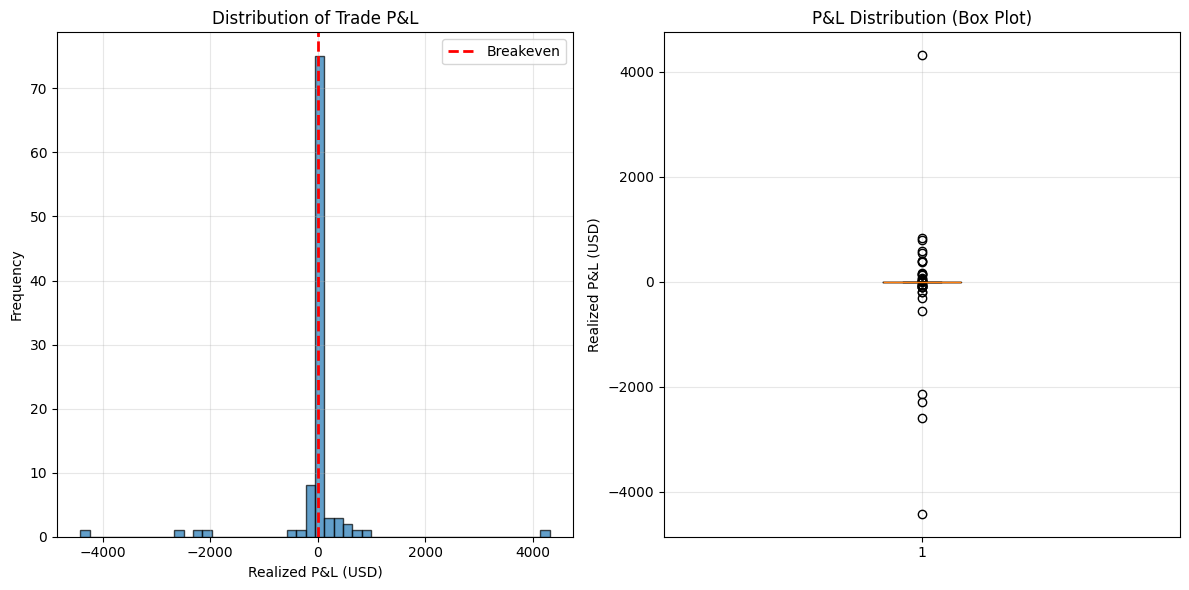

P&L STATISTICS
Mean P&L: $-41.81
Median P&L: $0.00
Std Dev: $763.06
Min: $-4,418.06
Max: $4,317.07
25th percentile: $0.00
75th percentile: $0.00


In [18]:
# Get all trades and analyze distribution
trades = get_trades_df(limit=10000)

if not trades.empty:
    # Plot histogram
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.hist(trades['realized_pnl'], bins=50, edgecolor='black', alpha=0.7)
    plt.xlabel('Realized P&L (USD)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Trade P&L')
    plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Breakeven')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Box plot
    plt.subplot(1, 2, 2)
    plt.boxplot(trades['realized_pnl'])
    plt.ylabel('Realized P&L (USD)')
    plt.title('P&L Distribution (Box Plot)')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistics
    print("=" * 60)
    print("P&L STATISTICS")
    print("=" * 60)
    print(f"Mean P&L: ${trades['realized_pnl'].mean():,.2f}")
    print(f"Median P&L: ${trades['realized_pnl'].median():,.2f}")
    print(f"Std Dev: ${trades['realized_pnl'].std():,.2f}")
    print(f"Min: ${trades['realized_pnl'].min():,.2f}")
    print(f"Max: ${trades['realized_pnl'].max():,.2f}")
    print(f"25th percentile: ${trades['realized_pnl'].quantile(0.25):,.2f}")
    print(f"75th percentile: ${trades['realized_pnl'].quantile(0.75):,.2f}")
else:
    print("No trades available for analysis")

### 6.3 Compare USD vs HKD P&L

In [19]:
# Compare USD and HKD P&L
trades = get_trades_df(limit=10000)

if not trades.empty:
    usd_total = trades['realized_pnl'].sum()
    hkd_total = trades['realized_pnl_hkd'].sum()
    fx_rate = hkd_total / usd_total if usd_total != 0 else 0
    
    print("=" * 60)
    print("USD vs HKD COMPARISON")
    print("=" * 60)
    print(f"Total P&L (USD): ${usd_total:,.2f}")
    print(f"Total P&L (HKD): HK${hkd_total:,.2f}")
    print(f"Effective FX Rate: {fx_rate:.4f}")
    
    # Show breakdown by currency
    print("\n" + "=" * 60)
    print("P&L BY CURRENCY")
    print("=" * 60)
    
    if 'currency' in trades.columns:
        by_currency = trades.groupby('currency').agg({
            'realized_pnl': 'sum',
            'realized_pnl_hkd': 'sum',
            'id': 'count'
        }).rename(columns={'id': 'trade_count'})
        
        print(by_currency.to_string())
    else:
        print("Currency column not available")
else:
    print("No trades available")
    print("Import trades first using:")
    print("  PYTHONPATH='$(pwd)' python -m backend.db_utils import")

USD vs HKD COMPARISON
Total P&L (USD): $-4,180.98
Total P&L (HKD): HK$-32,528.05
Effective FX Rate: 7.7800

P&L BY CURRENCY
          realized_pnl  realized_pnl_hkd  trade_count
currency                                             
HKD           0.000000          0.000000           17
JPY           0.000000          0.000000            3
USD       -4180.982737     -32528.045694           80


## 7. Visualizations

### 7.1 Daily P&L Chart

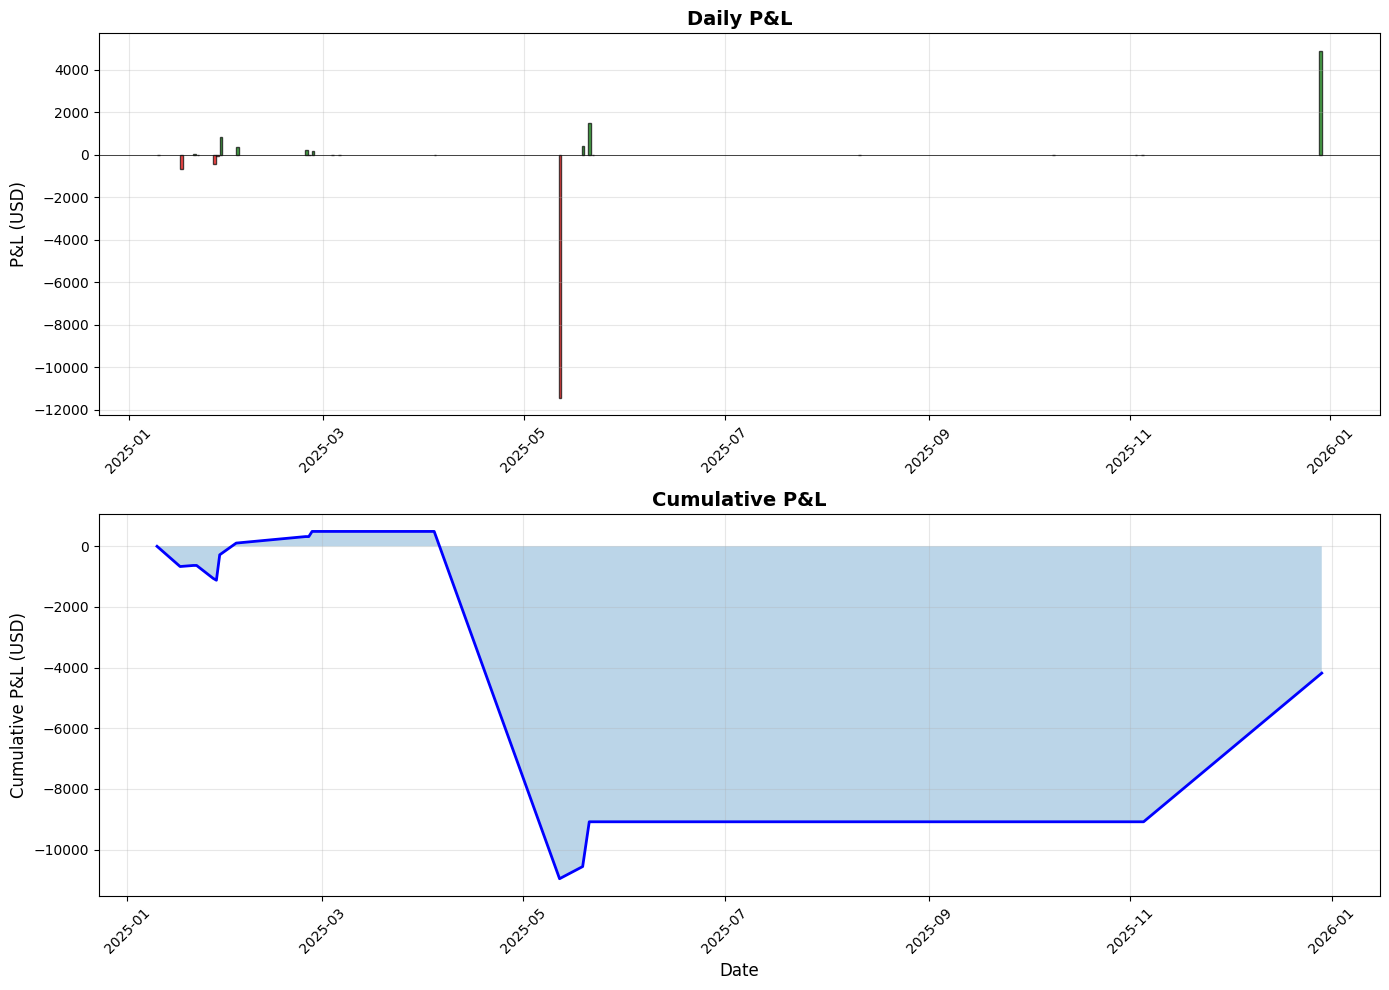

In [20]:
# Create daily P&L visualization
daily = get_daily_pnl()

if not daily.empty:
    # Ensure date is datetime
    if not pd.api.types.is_datetime64_any_dtype(daily['date']):
        daily['date'] = pd.to_datetime(daily['date'])
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Daily P&L bars
    colors = ['green' if x > 0 else 'red' for x in daily['realized_pnl']]
    ax1.bar(daily['date'], daily['realized_pnl'], color=colors, alpha=0.7, edgecolor='black')
    ax1.set_title('Daily P&L', fontsize=14, fontweight='bold')
    ax1.set_ylabel('P&L (USD)', fontsize=12)
    ax1.axhline(0, color='black', linestyle='-', linewidth=0.5)
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    
    # Cumulative P&L line
    if 'cumulative_pnl_usd' in daily.columns:
        ax2.plot(daily['date'], daily['cumulative_pnl_usd'], linewidth=2, color='blue')
        ax2.fill_between(daily['date'], daily['cumulative_pnl_usd'], alpha=0.3)
        ax2.set_title('Cumulative P&L', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Date', fontsize=12)
        ax2.set_ylabel('Cumulative P&L (USD)', fontsize=12)
        ax2.grid(True, alpha=0.3)
        ax2.tick_params(axis='x', rotation=45)
    else:
        # Calculate cumulative if not present
        daily['cumulative'] = daily['realized_pnl'].cumsum()
        ax2.plot(daily['date'], daily['cumulative'], linewidth=2, color='blue')
        ax2.fill_between(daily['date'], daily['cumulative'], alpha=0.3)
        ax2.set_title('Cumulative P&L', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Date', fontsize=12)
        ax2.set_ylabel('Cumulative P&L (USD)', fontsize=12)
        ax2.grid(True, alpha=0.3)
        ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
else:
    print("No daily P&L data available for visualization")
    print("Import trades first using:")
    print("  PYTHONPATH='$(pwd)' python -m backend.db_utils import")

### 7.2 Interactive Plotly Chart

In [21]:
# Create interactive Plotly chart
daily = get_daily_pnl()

if not daily.empty:
    # Ensure date is datetime
    if not pd.api.types.is_datetime64_any_dtype(daily['date']):
        daily['date'] = pd.to_datetime(daily['date'])
    
    fig = make_subplots(
        rows=2, cols=1,
        subplot_titles=('Daily P&L', 'Cumulative P&L'),
        vertical_spacing=0.1
    )
    
    # Daily P&L bars
    colors = ['green' if x > 0 else 'red' for x in daily['realized_pnl']]
    fig.add_trace(
        go.Bar(
            x=daily['date'], 
            y=daily['realized_pnl'], 
            marker_color=colors, 
            name='Daily P&L',
            hovertemplate='Date: %{x}<br>P&L: $%{y:,.2f}<extra></extra>'
        ),
        row=1, col=1
    )
    
    # Cumulative line - check if column exists
    cumulative_col = 'cumulative_pnl_usd' if 'cumulative_pnl_usd' in daily.columns else None
    if cumulative_col is None:
        # Calculate if not present
        daily['cumulative_pnl_usd'] = daily['realized_pnl'].cumsum()
        cumulative_col = 'cumulative_pnl_usd'
    
    fig.add_trace(
        go.Scatter(
            x=daily['date'], 
            y=daily[cumulative_col], 
            mode='lines', 
            name='Cumulative', 
            line=dict(width=2, color='blue'),
            fill='tozeroy',
            hovertemplate='Date: %{x}<br>Cumulative: $%{y:,.2f}<extra></extra>'
        ),
        row=2, col=1
    )
    
    fig.update_layout(
        height=800, 
        title_text="P&L Analysis Dashboard",
        showlegend=True
    )
    
    fig.update_xaxes(title_text="Date", row=2, col=1)
    fig.update_yaxes(title_text="P&L (USD)", row=1, col=1)
    fig.update_yaxes(title_text="Cumulative P&L (USD)", row=2, col=1)
    
    fig.show()
else:
    print("No daily P&L data available for visualization")
    print("Import trades first using:")
    print("  PYTHONPATH='$(pwd)' python -m backend.db_utils import")

### 7.3 Symbol Performance Comparison

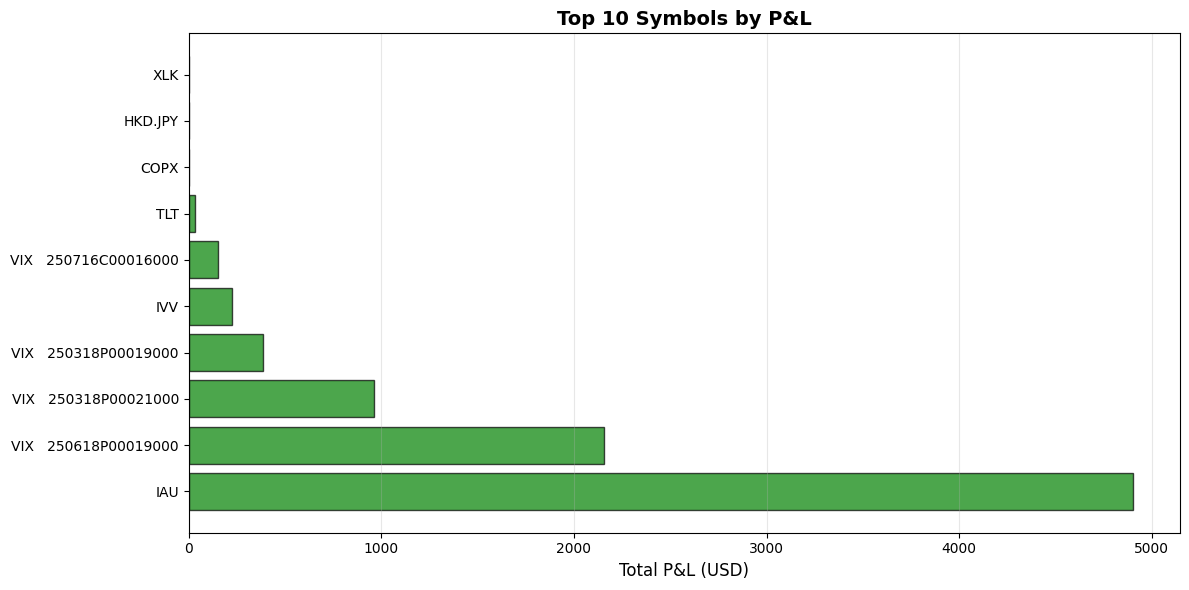

Top 10 Symbols:
               symbol  trade_count  realized_pnl_usd
                  IAU            8       4901.084827
VIX   250618P00019000            5       2154.384000
VIX   250318P00021000            8        961.121000
VIX   250318P00019000            2        386.845000
                  IVV            6        227.296297
VIX   250716C00016000            3        152.053500
                  TLT            6         33.179139
                 COPX            1          0.000000
              HKD.JPY            1          0.000000
                  XLK            1          0.000000


In [22]:
# Compare top symbols
summary = get_trade_summary()

if not summary.empty:
    top_10 = summary.head(10).reset_index()  # Reset index to get symbol as column
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    colors = ['green' if x > 0 else 'red' for x in top_10['realized_pnl_usd']]
    
    # Use symbol names for y-axis
    y_pos = range(len(top_10))
    ax.barh(y_pos, top_10['realized_pnl_usd'], color=colors, alpha=0.7, edgecolor='black')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(top_10['symbol'])
    ax.set_xlabel('Total P&L (USD)', fontsize=12)
    ax.set_title('Top 10 Symbols by P&L', fontsize=14, fontweight='bold')
    ax.axvline(0, color='black', linestyle='-', linewidth=0.5)
    ax.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()
    
    print("Top 10 Symbols:")
    print(top_10[['symbol', 'trade_count', 'realized_pnl_usd']].to_string(index=False))
else:
    print("No summary data available")
    print("Import trades first using:")
    print("  PYTHONPATH='$(pwd)' python -m backend.db_utils import")

## Summary

You've learned how to:

1. ✅ Query total P&L and trade counts
2. ✅ Get daily P&L with cumulative totals
3. ✅ Analyze P&L by symbol
4. ✅ Filter trades by date, symbol, side, currency
5. ✅ Write custom SQL queries
6. ✅ Calculate statistics and win rates
7. ✅ Create visualizations

### Next Steps

- Explore more SQL queries in the [DATABASE_GUIDE.md](../docs/DATABASE_GUIDE.md)
- Check the [PROJECT_DOCUMENTATION.md](../PROJECT_DOCUMENTATION.md) for full API reference
- Use the frontend dashboard at `http://localhost:8050` for real-time visualization

### Quick Reference

**CLI Commands:**
```bash
PYTHONPATH="$(pwd)" python -m backend.db_utils daily
PYTHONPATH="$(pwd)" python -m backend.db_utils summary
PYTHONPATH="$(pwd)" python -m backend.db_utils totals
```

**Python Functions:**
```python
from backend.db_utils import (
    get_trades_df,      # Get trades DataFrame
    get_daily_pnl,      # Get daily P&L
    get_trade_summary,  # Get summary by symbol
    get_account_pnl_totals,  # Get totals
    query_trades        # Run SQL
)
```